In [5]:
import numpy as np
import argparse
from custom_function import *
from glob import iglob
from collections import defaultdict
import scipy.ndimage
import scipy.io as sio
import sys
import os
import csv
from scipy.ndimage.interpolation import shift

def my_read_bin(cur_inp_file, data_type, input_shape):
  A = np.fromfile(cur_inp_file, dtype = data_type)
  A[np.isnan(A)] = 0
  A = np.reshape(A, input_shape)
  A = np.transpose(A, [2, 1, 0])
  return A

def center_to_def_loc(SA_rec, cur_loc, offset):
  SA_rec_sliced = SA_rec[:,:,cur_loc[2]+offset]
  sh_x = SA_rec_sliced.shape[1]//2 - cur_loc[0]
  sh_y = SA_rec_sliced.shape[0]//2 - cur_loc[1]
  SA_rec_sh = shift(SA_rec_sliced, [sh_y, sh_x], prefilter=False)
  return SA_rec_sh

def run_cho(dl_version, Ud, dose_level, isIO, bt_size, lambda_val_ind_chdiff, lambda_val_ind_mdiff):
  base_folder_data='/datastore01/user-storage/y.zezhang/2025_high_dose_project/data/neural_network_data/testing'
  base_folder = '/datastore01/user-storage/y.zezhang/2025_high_dose_project/mod_neural_network_training'#################################################
  root_folder = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred'; #####################################################################################
  root_folder_mirirv3 = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred_mirirv3'########################################################################
  root_folder_prev = f'{base_folder_data}/test_data_sa_wd';###########################################################################################
  root_folder_prev_mirirv3 = f'{base_folder_data}/test_data_mirirv3_sa_wd';##############################################################################
  save_folder = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred_tSN_fix3_ms_comb_mirirv3/lmbd_mdiff{lambda_val_ind_mdiff}/d{dose_level}'###########
  #if not os.path.isdir(save_folder):
  #  os.mkdir(save_folder)
  os.makedirs(save_folder, exist_ok=True)

  inp_shape = (48, 48, 48)
  inp_shape_orig = (48, 48, 48)

  # loading patient list
  hl_pat_list_fname = f'{base_folder}/final_test_pat_list_hl.txt'
  hl_pat_list = np.loadtxt(hl_pat_list_fname, dtype=str)

  def_pat_list_fname = f'{base_folder}/final_test_pat_list_def.txt'
  def_pat_list = np.loadtxt(def_pat_list_fname, dtype=str)

  hl_pat_list_fname = f'{base_folder}/final_test_pat_list_hl_src.txt'
  hl_pat_list_src = np.loadtxt(hl_pat_list_fname, dtype=str)

  def_pat_list_fname = f'{base_folder}/final_test_pat_list_def_src.txt'
  def_pat_list_src = np.loadtxt(def_pat_list_fname, dtype=str)

  print('loading pre-written channels file...')
  if Ud == 32:
    U_flag = ''
  elif Ud == 64:
    U_flag = f'_{Ud}'

  U = np.load(f'{base_folder}/U{U_flag}.npy')
  print('U shape: ',U.shape)
  U = np.transpose(U, [1,0])

  print(f'loading images... || D: {dose_level}')
  ff = {'diseased':defaultdict(list), 'healthy':defaultdict(list)}
  pat_ind_arr = {'diseased':def_pat_list, 'healthy':hl_pat_list}
  pat_ind_arr_src = {'diseased':def_pat_list_src, 'healthy':hl_pat_list_src}

  def_name_arr = []
  for diag in ['diseased', 'healthy']:
    for idx_list in range(len(pat_ind_arr[diag])):
      pat_ind = pat_ind_arr[diag][idx_list]
      src_name = pat_ind_arr_src[diag][idx_list]
      #print(pat_ind)
      subensemble_idx = 0
      for location in ['a','i']:
        #for extent in [30,45,60]:
        for extent in [30,60]:
          for severity in [100,175,250]:
            if diag == 'diseased':
              def_name = f'd{location}21{extent}s{severity}'
              def_name_mod = ''
              centroid_fname_flag = '_mod'
            else:
              def_name = f'hl'
              def_name_mod = f'hl'
              centroid_fname_flag = '_mod_again3'

            if src_name == 'mirirv3':
              centroid_fname_flag = '_mod'
              root_folder_act = root_folder_mirirv3
              root_folder_prev_act = root_folder_prev_mirirv3
            else:
              root_folder_act = root_folder
              root_folder_prev_act = root_folder_prev

            def_name_arr.append(f'd{location}21{extent}s{severity}')
            SA_name = \
              f'{root_folder_act}/{def_name}/recon_pat{pat_ind}' + \
              f'_{def_name}_d{dose_level}_it8' + \
              f'_b{bt_size}_lmbdchdiff{lambda_val_ind_chdiff}_lmbdmdiff{lambda_val_ind_mdiff}.img'
              #f'_c30o5.img'
            def_loc_fname = \
              f'{root_folder_prev_act}/{pat_ind}/def_centroid_d{location}21{extent}{centroid_fname_flag}.bin'
            cur_loc = np.fromfile(def_loc_fname, dtype = 'float32').astype(int) - 1 #0 -based / but nn2D has 1 shift

            
            SA_rec_base = my_read_bin(SA_name, 'float32', inp_shape_orig)
            #print(SA_rec.shape)
            for offset in [7,8,9]:
              SA_rec = center_to_def_loc(SA_rec_base, cur_loc, offset)
              SA_rec = SA_rec[8:40,8:40]
              if Ud != 32:
                SA_rec = scipy.ndimage.zoom(SA_rec, Ud/32, order=0) # upsampling to 512X512
              SA_rec = (SA_rec-np.min(SA_rec))/(np.max(SA_rec)-np.min(SA_rec))*255
              SA_rec = SA_rec - np.mean(SA_rec) # remove zero frequency component
              ff[diag][subensemble_idx].append(SA_rec.flatten())
            if isIO == 1:
              subensemble_idx += 1

  #np.save(f'{root_folder}/SA_rec_d{location}21{extent}.npy', SA_rec)
  ###################################################################

  print('calculating test statistics...')
  tS_sum = []
  tN_sum = []


/tmp/ipykernel_1605024/741283757.py:11: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [9]:

dl_version='2sh'
batch_size=32
#dose_level=${1}
dose_level=33

lambda_val_ind_mdiff=0
#lambda_val_ind_chdiff=${2}
lambda_val_ind_chdiff=6
Ud = 32
isIO = 0


In [13]:
bt_size=32

In [14]:

  base_folder_data='/datastore01/user-storage/y.zezhang/2025_high_dose_project/data/neural_network_data/testing'
  base_folder = '/datastore01/user-storage/y.zezhang/2025_high_dose_project/mod_neural_network_training'#################################################
  root_folder = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred'; #####################################################################################
  root_folder_mirirv3 = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred_mirirv3'########################################################################
  root_folder_prev = f'{base_folder_data}/test_data_sa_wd';###########################################################################################
  root_folder_prev_mirirv3 = f'{base_folder_data}/test_data_mirirv3_sa_wd';##############################################################################
  save_folder = f'{base_folder}/learning/highdose_3d_v{dl_version}/pred_tSN_fix3_ms_comb_mirirv3/lmbd_mdiff{lambda_val_ind_mdiff}/d{dose_level}'###########
  #if not os.path.isdir(save_folder):
  #  os.mkdir(save_folder)
  os.makedirs(save_folder, exist_ok=True)

  inp_shape = (48, 48, 48)
  inp_shape_orig = (48, 48, 48)

  # loading patient list
  hl_pat_list_fname = f'{base_folder}/final_test_pat_list_hl.txt'
  hl_pat_list = np.loadtxt(hl_pat_list_fname, dtype=str)

  def_pat_list_fname = f'{base_folder}/final_test_pat_list_def.txt'
  def_pat_list = np.loadtxt(def_pat_list_fname, dtype=str)

  hl_pat_list_fname = f'{base_folder}/final_test_pat_list_hl_src.txt'
  hl_pat_list_src = np.loadtxt(hl_pat_list_fname, dtype=str)

  def_pat_list_fname = f'{base_folder}/final_test_pat_list_def_src.txt'
  def_pat_list_src = np.loadtxt(def_pat_list_fname, dtype=str)

  print('loading pre-written channels file...')
  if Ud == 32:
    U_flag = ''
  elif Ud == 64:
    U_flag = f'_{Ud}'

  U = np.load(f'{base_folder}/U{U_flag}.npy')
  print('U shape: ',U.shape)
  U = np.transpose(U, [1,0])

  print(f'loading images... || D: {dose_level}')
  ff = {'diseased':defaultdict(list), 'healthy':defaultdict(list)}
  pat_ind_arr = {'diseased':def_pat_list, 'healthy':hl_pat_list}
  pat_ind_arr_src = {'diseased':def_pat_list_src, 'healthy':hl_pat_list_src}

  def_name_arr = []
  for diag in ['diseased', 'healthy']:
    for idx_list in range(len(pat_ind_arr[diag])):
      pat_ind = pat_ind_arr[diag][idx_list]
      src_name = pat_ind_arr_src[diag][idx_list]
      #print(pat_ind)
      subensemble_idx = 0
      for location in ['a','i']:
        #for extent in [30,45,60]:
        for extent in [30,60]:
          for severity in [100,175,250]:
            if diag == 'diseased':
              def_name = f'd{location}21{extent}s{severity}'
              def_name_mod = ''
              centroid_fname_flag = '_mod'
            else:
              def_name = f'hl'
              def_name_mod = f'hl'
              centroid_fname_flag = '_mod_again3'

            if src_name == 'mirirv3':
              centroid_fname_flag = '_mod'
              root_folder_act = root_folder_mirirv3
              root_folder_prev_act = root_folder_prev_mirirv3
            else:
              root_folder_act = root_folder
              root_folder_prev_act = root_folder_prev

            def_name_arr.append(f'd{location}21{extent}s{severity}')
            SA_name = \
              f'{root_folder_act}/{def_name}/recon_pat{pat_ind}' + \
              f'_{def_name}_d{dose_level}_it8' + \
              f'_b{bt_size}_lmbdchdiff{lambda_val_ind_chdiff}_lmbdmdiff{lambda_val_ind_mdiff}.img'
              #f'_c30o5.img'
            def_loc_fname = \
              f'{root_folder_prev_act}/{pat_ind}/def_centroid_d{location}21{extent}{centroid_fname_flag}.bin'
            cur_loc = np.fromfile(def_loc_fname, dtype = 'float32').astype(int) - 1 #0 -based / but nn2D has 1 shift

            
            SA_rec_base = my_read_bin(SA_name, 'float32', inp_shape_orig)
            #print(SA_rec.shape)
            for offset in [7,8,9]:
              SA_rec = center_to_def_loc(SA_rec_base, cur_loc, offset)
              SA_rec = SA_rec[8:40,8:40]
              if Ud != 32:
                SA_rec = scipy.ndimage.zoom(SA_rec, Ud/32, order=0) # upsampling to 512X512
              SA_rec = (SA_rec-np.min(SA_rec))/(np.max(SA_rec)-np.min(SA_rec))*255
              SA_rec = SA_rec - np.mean(SA_rec) # remove zero frequency component
              ff[diag][subensemble_idx].append(SA_rec.flatten())
            if isIO == 1:
              subensemble_idx += 1

  #np.save(f'{root_folder}/SA_rec_d{location}21{extent}.npy', SA_rec)
  ###################################################################

  print('calculating test statistics...')
  tS_sum = []
  tN_sum = []

loading pre-written channels file...
U shape:  (1024, 4)
loading images... || D: 33
calculating test statistics...


In [16]:
import matplotlib.pyplot as plt

def_name = f'd{location}21{extent}s{severity}'
def_name_mod = ''
centroid_fname_flag = '_mod'

In [18]:
            def_name_arr.append(f'd{location}21{extent}s{severity}')
            SA_name = \
              f'{root_folder_act}/{def_name}/recon_pat{pat_ind}' + \
              f'_{def_name}_d{dose_level}_it8' + \
              f'_b{bt_size}_lmbdchdiff{lambda_val_ind_chdiff}_lmbdmdiff{lambda_val_ind_mdiff}.img'
              #f'_c30o5.img'
            def_loc_fname = \
              f'{root_folder_prev_act}/{pat_ind}/def_centroid_d{location}21{extent}{centroid_fname_flag}.bin'
            cur_loc = np.fromfile(def_loc_fname, dtype = 'float32').astype(int) - 1 #0 -based / but nn2D has 1 shift

            
            SA_rec_base = my_read_bin(SA_name, 'float32', inp_shape_orig)
            offset=7

In [23]:
SA_name

'/datastore01/user-storage/y.zezhang/2025_high_dose_project/mod_neural_network_training/learning/highdose_3d_v2sh/pred_mirirv3/di2160s250/recon_pat25400641_di2160s250_d33_it8_b32_lmbdchdiff6_lmbdmdiff0.img'

In [24]:
cur_loc

array([29, 31, 16])

In [21]:
SA_rec_sliced = SA_rec_base [:,:,cur_loc[2]+offset]
sh_x = SA_rec_sliced.shape[1]//2 - cur_loc[0]
sh_y = SA_rec_sliced.shape[0]//2 - cur_loc[1]
SA_rec_sh = shift(SA_rec_sliced, [sh_y, sh_x], prefilter=False)

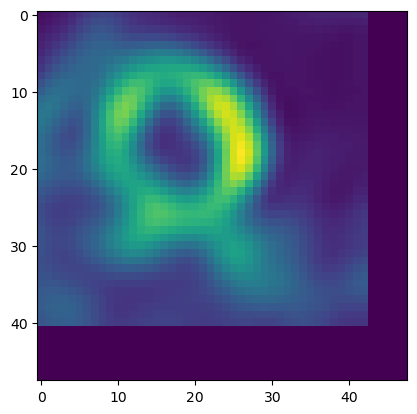

In [22]:
plt.imshow(SA_rec_sh[:,:])